In [11]:
import pandas as pd
from pathlib import Path
import time
from os import path
import seaborn as sns

from preprocessing.exoplanets_gaia_crossmatch import gaia_exoplanets_cross, transform_to_cart
from preprocessing.download_gaia import GaiaDataset
from preprocessing.calc_density import get_densities
from models.gaussian_mixture import remove_outliers, gaussian_mixture
from models.classification import random_forest as rfc
from models.regression import random_forest as rfr
from models.regression import RadialVelocityRegression, ann
from sklearn.metrics import r2_score
from graphs.mixture_fit import best_fit_mixture
from preprocessing.read_winter import load_winter
from IPython.display import Image
from PIL import Image as pil_img
import matplotlib.image as mpimg
import matplotlib.patches as mpatches

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import shutil

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


# 1. Preprocessing functions

In [10]:
def download_gaiadr2():
    query = f"""
            select source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, pmra, pmra_error, pmdec, 
            pmdec_error, radial_velocity, radial_velocity_error from gaiadr2.gaia_source where source_id is not null 
            and ra is not null and ra_error is not null and dec is not null and dec_error is not null and parallax 
            is not null and parallax_error is not null and pmra is not null and pmra_error is not null and pmdec is 
            not null and pmdec_error is not null and radial_velocity is not null and radial_velocity_error is not null
            """

    g = GaiaDataset(query=query, filename="gaiadr2_table")
    g.get_gaia()

In [4]:
def exoplanet_gaia_crossmatch(crossmatch_dir, transform_type="6d", table_name="gaiaedr3", save_spherical=True):
    """
    :param: transform_type: Type of coordinates transformation to perform on the data (6d, 5d_drop_vx, 5d_drop_vy or 5d_drop_vz).
    :param: table_name: Name of the Gaia dataset to use.
    :param: save_spherical: Save spherical values to a CSV file. When looping it is adviced to apply only once to save time. 
    
    :return: Density values for 1065 exoplanets and their neighbours, Winter-Gaia-NASA exoplanet archive crossmatch
    table containing 6D coordinates only and Winter-Gaia-NASA exoplanet archive crossmatch table with data from all 3
    sources combined.
    """

    # Cross match datasets and generate new ones.
    gaia = gaia_exoplanets_cross(f"{table_name}.csv", crossmatch_dir, save_gaia_id=True, return_data=True, save_spherical=save_spherical)
    transform_to_cart(gaia, table_name, crossmatch_dir, setting=transform_type)

In [3]:
def calculate_densities(star_labels_filename, dataset_filename, crossmatch_dir, densities_dir, exoplanets_only=True, n_stars=None, run_on_gpu=False):
    """
    Calculate phase space density for given set of stars.
    
    :param: star_labels_filename: Name of the file containing star labels.
    :param: dataset_filename: Name of the file containing coordinates of the stars.
    :param: exoplanets_only: Compute density only for a list of exoplanets (~1000).
    :param: n_stars: Numeber of stars to calculate density for.
    :param: run_on_gpu: Use GPU accelerated pipeline.
    """
    
    labels_file = pd.read_csv(os.path.join(crossmatch_dir, star_labels_filename), dtype={"source_id": np.float64, "Host": np.object})
    gaia = pd.read_csv(os.path.join(crossmatch_dir, dataset_filename))
                
    if gaia.shape[1] == 6:
        name = dataset_filename.split("_")[0] + f"_{dataset_filename[-6:-4]}"
    else:
        name = dataset_filename.split("_")[0] + f"_{dataset_filename[-14:-4]}"
            
    if exoplanets_only:
        labels = labels_file["Host"].dropna()
        n_stars = labels.shape[0]
        name = name + "_only-" + dataset_filename.split("_")[1] + "s"
    else:
        labels = labels_file["source_id"]
        name = name + f"_{str(n_stars)}-stars"


    densities, dropped = get_densities(n_stars, labels.to_numpy(), gaia.to_numpy(), run_on_gpu=run_on_gpu)
    
    with open(f"{densities_dir}/densities_{name}.data", "wb") as f:
        pickle.dump(densities, f)
    with open(f"{densities_dir}/dropped_densities_{name}.data", "wb") as f:
        pickle.dump(dropped, f)

In [74]:
def fit_gaussian_mixture(file_name, classification_dir, densities_dir, show_graph=False, save_graph=False):
    """
    :param: star_labels_filename:
    """
    sigma = 2
    fig_dir=None
    file_name = file_name.split(".")[0]
    if save_graph:  
        if os.path.isdir(f"figures/{file_name}"):
            shutil.rmtree(f"figures/{file_name}")
        fig_dir = file_name
    
        os.mkdir(f"figures/{fig_dir}")
    
    with open(f"{densities_dir}/{file_name}.data", "rb") as f:
        densities = pickle.load(f)
    
    results = []
    for i in densities:
        # Compute log10 of the host density and expand dimensions for further use
        target = np.expand_dims(np.log10(i[1]), axis=0).T

        # Remove outliers outside sigma
        data = remove_outliers(i[4], sigma=sigma)
        
        # Apply gaussian mixture model to the data
        model, scores = gaussian_mixture(data, [target], components=2, scores_only=False)

        # Create list consisting of star name and its density for graph drawing
        scores.insert(0, target[0])
        scores.insert(0, i[4].shape[0])
        scores.insert(0, i[0])
        
        results.append(scores)
        
        # Draw best fit mixture
        if type(i[0]) != str:
            host = [f"{i[0]:.0f}", target]
        else:
            host = [i[0], target]

        if show_graph or save_graph:
            best_fit_mixture(model, data, host, fig_dir, show_graph, save_graph)

    
    df = pd.DataFrame(results, columns=["Host", "n_stars", "density", "Plow", "Phigh", "mean_low", "mean_high", "cov_low",
                                        "cov_high", "aic", "bic"])
    df.to_csv(f"{classification_dir}/features_{file_name}.csv")

In [13]:
crossmatch_dir = "data/crossmatch/dr2"
densities_dir = "data/densities/dr2"
classification_dir = "data/classification/dr2"
datasets_dir = "data/initial_datasets"

In [15]:
if not os.path.exists(crossmatch_dir):
    os.mkdir(crossmatch_dir)
if not os.path.exists(densities_dir):
    os.mkdir(densities_dir)
if not os.path.exists(classification_dir):
    os.mkdir(classification_dir)
if not os.path.exists(datasets_dir):
    os.mkdir(datasets_dir)

# 1. Creation of robust pipeline

### All code was developed throught multiple testing iterations and comparison of results to A. Winter work. Below are the results of a single run that produce data and compares the results of Gaussian Mixture prediction to the values from Winter table.

## 1.1 Download Gaia dataset

In [11]:
download_gaiadr2()

OK
INFO: Query finished. [astroquery.utils.tap.core]


## 1.2 Crossmatch NASA Exoplanet dataset with Gaia dataset

In [5]:
exoplanet_gaia_crossmatch(crossmatch_dir=crossmatch_dir, transform_type="6d", table_name="gaiadr2", save_spherical=True)
exoplanet_gaia_crossmatch(crossmatch_dir=crossmatch_dir, transform_type="5d_drop_vz", table_name="gaiadr2", save_spherical=False)

## 1.3 Calculate phase space density for neighbours of exoplanet hosts

In [4]:
for fname in os.listdir(crossmatch_dir):
    if "cartesian" in fname:
        start = time.perf_counter()
        calculate_densities("gaiadr2_star_labels.csv", fname, crossmatch_dir, densities_dir, exoplanets_only=True, run_on_gpu=True)
        end = time.perf_counter()
        print(f"{fname} completed in: {str(end-start)}")

gaiadr2_exoplanet_cross_cartesian_5d_drop_vz.csv completed in: 832.0416730769975
gaiadr2_exoplanet_cross_cartesian_6d.csv completed in: 963.1655449440004


## 1.4 Fit gaussian mixture model to predict if target star belongs to overdensity or underdensity group. Return scores and attributes of the model.

In [3]:
for fname in os.listdir(densities_dir):
    if "dropped" in fname:
        continue
    if "only-exoplanets" in fname:
        fit_gaussian_mixture(fname, classification_dir, densities_dir, show_graph=False, save_graph=True)

NameError: name 'fit_gaussian_mixture' is not defined

## 1.5 Comparison with A. Winter Phigh results

In [4]:
def hue(row):
    # MissmatchedPlow and Phigh
    if ((row["Phigh"] > 0.84) & (row["logPhigh"] < 0.16)) | ((row["Phigh"] < 0.16) & (row["logPhigh"] > 0.84)):
        val = 0
    # Missmatched Phigh for ambigous
    elif ((row["Phigh"] > 0.84) & (row["logPhigh"] < 0.84)) | ((row["Phigh"] < 0.84) & (row["logPhigh"] > 0.84)):
        val = 1   
    # Missmatched Plow for ambigous
    elif ((row["Phigh"] < 0.16) & (row["logPhigh"] > 0.16)) | ((row["Phigh"] > 0.16) & (row["logPhigh"] < 0.16)):
        val = 2
    # Ambigous group
    elif ((row["Phigh"] < 0.84) & (row["logPhigh"] > 0.16)) | ((row["Phigh"] > 0.16) & (row["logPhigh"] < 0.84)):
        val = 3
    # Matching values
    else:
        val = 4
    return val

In [5]:
df = pd.read_csv(os.path.join(classification_dir, "features_densities_gaiadr2_6d_only-exoplanets.csv"), index_col=0)
winter = load_winter()

In [6]:
df1 = pd.merge(df, winter, on="Host")
df1["logPhigh"] = 10 ** df1["logPhigh"]
df1 = df1[["Host", "Phigh", "logPhigh"]]
df1["hue"] = df1.apply(hue, axis=1)

In [10]:
df1["hue"].value_counts()

4    599
1    140
3    104
2     97
0     23
Name: hue, dtype: int64

In [13]:
df1[df1["hue"] == 0]

,Host,Phigh,logPhigh,hue
51,GJ676A,0.959875,2.691535e-02,0
135,HD10697,0.952815,2.344229e-02,0
162,HD125390,0.987659,3.311311e-06,0
191,HD142022A,0.994038,6.918310e-03,0
247,HD170469,0.975872,2.570396e-02,0
259,HD177830,0.924225,4.897788e-02,0
329,HD219415,0.988621,6.918310e-08,0
365,HD28678,0.977689,1.122018e-01,0
369,HD30177,0.973751,4.570882e-02,0
376,HD32518,0.856919,7.244360e-02,0


In [ ]:
colors = ["blue", "m", "red", "orange", "green"]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), facecolor="w")

sns.scatterplot(x=df1["Phigh"], y=df1["logPhigh"], hue=df1["hue"], palette=colors, ax=ax)

# Set legend
blue_patch = mpatches.Patch(color=colors[0], label="Missmatched Plow for Phigh")
magenta_patch = mpatches.Patch(color=colors[1], label="Missmatched Phigh for ambigous")
red_patch = mpatches.Patch(color=colors[2], label="Missmatched Plow for ambigous")
orange_patch = mpatches.Patch(color=colors[3], label="Ambigous")
green_patch = mpatches.Patch(color=colors[4], label="Matching Phigh and Plow")
plt.legend(handles=[blue_patch, magenta_patch, red_patch, orange_patch, green_patch], bbox_to_anchor=(0., 1.02, 1., .102), 
           loc="lower left", ncol=3, mode="expand", borderaxespad=0.);

plt.xlabel("Density prediction (All neighbours)")
plt.ylabel("Winter density prediction (600 random neighbours)")

plt.savefig("report_images/winter_comparison.png")

## Gassuain mixture fit comparison graphs

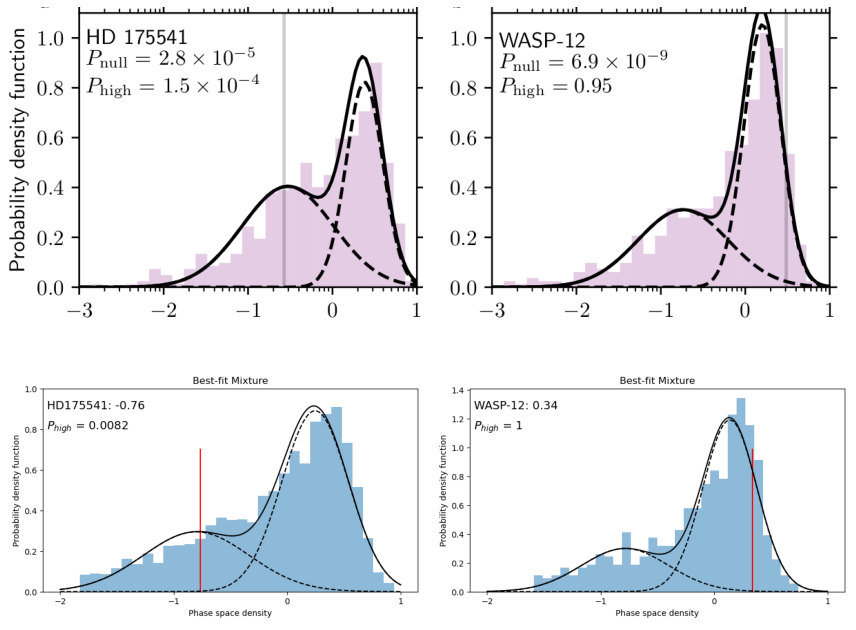

In [255]:
# read images
img_A = mpimg.imread("figures/densities_gaiaedr3_6d_only-exoplanets/HD175541.png")
img_B = mpimg.imread("figures/densities_gaiaedr3_6d_only-exoplanets/WASP-12.png")
winter_A = mpimg.imread("winter_figures/HD175541.png")
winter_B = mpimg.imread("winter_figures/WASP-12.png")

# display images
fig, ax = plt.subplots(2,2, figsize=(12,10), facecolor="w")
ax[0][0].imshow(winter_A)
ax[0][0].axis("off")
ax[0][1].imshow(winter_B)
ax[0][1].axis("off")
ax[1][0].imshow(img_A)
ax[1][0].axis("off")
ax[1][1].imshow(img_B)
ax[1][1].axis("off")

fig.tight_layout()
plt.savefig("report_images/star_density_comparison.png")